<a href="https://colab.research.google.com/github/amazzoli/RL_introduction/blob/main/notebooks/Gridworld_with_Value_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gridworld

*Andrea Mazzolini*, andrea.mazzolini.90@gmail.com.

<br/><br/>

Here we want to find the optimal strategy of a 2d grid-world problem using a model-based algorithm: **Value iteration**.

## Gridworld as a Markov Decision Process

### States
The state space is the physical cartesian space of the gridworld, identified by the two coordinates.
Assuming that it is a square of side $d$, the whole state space is composed of $d^2$ states:

$$
\mathcal{S} = \{ 0, 1, \ldots, d-1 \} \times \{ 0, 1, \ldots, d-1 \}
$$

### Actions
The actions of the agent are five: they can move to nearest neighbors or stay in the cell without moving, which can be expressed also as translation vectors.

$$
\mathcal{A} = \{ \text{up}, \text{left}, \text{down}, \text{right}, \text{stay} \} = \{ (0,1), (-1,0), (0,-1), (1,0), (0,0)\}
$$

Actually, these actions are not always possible in each state: the agent cannot cross boundaries or possible internal obstacles.
This makes actions state dependent, for example if the agent is located on the left boundary they cannot go left, $\mathcal{A}(0,y) = \{ \text{up}, \text{down}, \text{right}, \text{stay} \}$, or in a corner: $\mathcal{A}(d-1,d-1) = \{ \text{left}, \text{down}, \text{stay} \}$.

### Transition probabilities

The transition probabilities between states are deterministic: the next state is just the old state plus the translation action chosen by the agent:

$$
p(s_{t+1} | a_t, s_t) = \delta (s_{t+1} - (a_t + s_t))
$$

### Rewards

The rewards depend only on the arrival states, $r(s_{t+1})$, and are zero for all the states with the exception of some special cells that contain a treasure.
Here we decide to not delete the treasure after the agent arrives on the cell, in a way that if they decide to stay they can collect the reward also at the future steps.

### Aim of the game

The agent has to learn to get the treasure by following the fastest path from a given initial cell.
In formula, we want to maximize the return

$$
G_\pi = \sum_{t=0}^\infty \gamma^t\, R_{t,\pi} ,
$$

where $\gamma$, the time horizon, introduces the time scale within which we want to acquire the treasure and $R$ is the stochastic variable corresponding to the reward acquired at time $t$ following the policy $\pi$.
The policy $\pi(a | s)$ is our strategy that gives the probability of choosing $a \in \mathcal{A}(s)$ (the direction of the next step) from state $s$ (the coordinate in which we are), therefore is telling us how to navigate the map.

## Value iteration

### The Bellman equation

The value iteration algorithm is a simple iterative map that finds the numerical solution of the Bellman equations, which read, for every state $s$:

$$
V^*(s) = \max_a \sum_{s'} p(s'|s,a) \left( r(s', a, s) + \gamma V^*(s') \right) ,
$$

where the main variable is the value of a state, $V^*(s)$, representing the best return one can get starting from $s$.
Once the values are known, one can find the quality of an action-state pair, $Q^*(s,a) = \sum_{s'} p(s'|s,a) \left( r(s', a, s) + \gamma V^*(s') \right)$, i.e. the best possible return from state $s$ and choosing $a$.
From this object is then trivial to choose the best policy, which corresponds to the action having the best quality:

$$
\pi^*(a | s) = \delta \left( a - \text{argmax}_b Q^*(s,b) \right)
$$

### Solving iteratively

The value iteration algorithm proposes an iterative solution of the Bellman equations. One assumes a whatever initial guess for the values, $V^{(0)}(s)$, and then for each further iteration the value at the next step is given the Bellman equation that uses the values at the previous step.

The pseudocode is the following:
- Choose an initial value for each state $V^{(0)}(s)$.
- Iterate over $t$ until convergence, e.g. $\max_s |V^{(t+1)}(s) - V^{(t)}(s)| < ϵ$:
> - Update the values with
> $$V^{(t+1)}(s) = \max_a \sum_{s'} p(s'|s,a) \left( r(s', a, s) + \gamma V^{(t)}(s') \right)$$

This procedure guarantees that one always reaches convergence and that $\lim_{t → ∞} V^{(t)}(s) = V^*(s)$. It can be mathematically proven that this iterative map is convex and will always reach the fix point  $V^*(s)$ from any initial condition $V^{(0)}(s)$.



## Implementation

### Environment class: the gridworld

The Gridworld class contains all the information about the environment:
- The info about the state space, the current state of the game and the initial state.
- The set of possible actions.
- The reward table: which reward the agent takes in each cell (0 if none).

In [1]:
import numpy as np
from copy import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm


class Gridworld:

  def __init__(self, grid_size, init_cell, rewards, obstacles=[]):
    """
    Training environment for reinforcement learning: gridworld.
    Args:
    - grid_size, (int, int): defining the size of the 2d lattice
    - init_cell, (int, int): coordinates from 0 to size-1 from which the agent starts to play
    - rewards, list((int, int), float): list of the coordinates and values of the rewards
    - obstacles, lits((int, int)): list of the coordinates of the obstacles
    """

    # Define state space
    self.state = None  # current state of the game
    self.state_dim = grid_size
    self.init_state = init_cell
    self.obstacles = obstacles
    # Cells that are not obstacles
    self.states = [(i,j) for i in range(self.state_dim[0]) for j in range(self.state_dim[1]) if (i,j) not in self.obstacles]

    # Define action space
    self.action_dim = (5,)  # up, right, down, left, stay
    self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3, "stay": 4}
    self.action_coords = [(0, 1), (1, 0), (0, -1), (-1, 0), (0, 0)]  # translations
    self.actions_allowed = self._build_allowed_actions(obstacles)

    # Define rewards table
    self.R = self._build_rewards(rewards)


  def _build_allowed_actions(self, obstacles):
    actions_allowed = dict()
    Nx, Ny = self.state_dim
    for x in range(Nx):
      for y in range(Ny):
        # Actions not allowed at the boundaries
        actions_allowed[(x,y)] = [self.action_dict["stay"]] # The stay action is always allowed
        if (y > 0):
          actions_allowed[(x,y)].append(self.action_dict["down"])
        if (y < Ny - 1):
          actions_allowed[(x,y)].append(self.action_dict["up"])
        if (x > 0):
          actions_allowed[(x,y)].append(self.action_dict["left"])
        if (x < Nx - 1):
          actions_allowed[(x,y)].append(self.action_dict["right"])
        actions_allowed[(x,y)] = np.array(actions_allowed[(x,y)], dtype=int)
        # Actions not allowed because of obstacles
        for o in obstacles:
          if (x+1,y) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["right"]]
          if (x-1,y) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["left"]]
          if (x,y+1) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["up"]]
          if (x,y-1) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["down"]]
    return actions_allowed


  def _build_rewards(self, rewards):
      R = np.zeros(self.state_dim, dtype=float)
      for rew in rewards:
        R[rew[0]] = rew[1]
      return R

  def display(self, ax, values=np.array([]), cmap=cm["Reds"]):
    """
    Plot the map on the axis object ax. It's possible to add a color to each cell, e.g. its value,
    by passing a properly sized vectors of values
    """

    cmap.set_bad("black")
    obstacle_mask = np.zeros(self.state_dim, dtype=bool)
    for obs in obstacles:
      obstacle_mask[obs[0], obs[1]] = True

    if len(values)==0:
      ax = sns.heatmap(obstacle_mask.T, cmap=cm["Greys"], cbar=False,
                       linewidths=0.1, linecolor='#222222')
    else:
      ax = sns.heatmap(values.T, mask=obstacle_mask.T, cmap=cmap,
                       linewidths=0.1, linecolor='#222222', vmin=np.min(values[values != 0]))
      ax.collections[0].colorbar.set_label("Value", fontsize=14)

    ax.invert_yaxis()
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.scatter([start_cell[0]+0.5],[start_cell[1]+0.5], s=100, c='grey', label='Start')
    for rew in rewards:
      ax.scatter([rew[0][0]+0.5],[rew[0][1]+0.5], s=200*rew[1], c='#ffcc00', label='Reward:{}'.format(rew[1]), marker='*')

    return ax


  def display_best_path(self, ax, Q, start_coord, lcolor='black', values=np.array([]), cmap=cm["Reds"]):
    """
    Plot the map and display the best path on the axis object ax.
    """

    ax = self.display(ax, values, cmap)

    s, count, best_action = start_coord, 0, 0
    while best_action != 4 or count < self.state_dim[0]*self.state_dim[1]:
      count += 1
      best_action = np.argmax(Q[s[0], s[1], :])
      new_s = s[0] + self.action_coords[best_action][0], s[1] + self.action_coords[best_action][1]
      ax.plot([s[0]+0.5, new_s[0]+0.5], [s[1]+0.5, new_s[1]+0.5], c='black', lw=3)
      s = new_s

    return ax

### Building the gridworld

We build a griword with two rewards: one large and far away from the starting state, one smaller and closer.

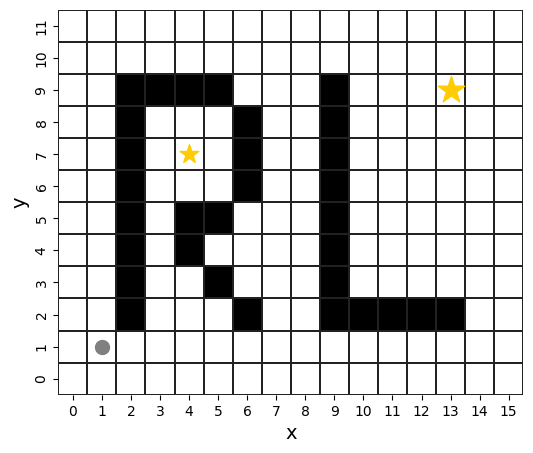

In [2]:
world_size = (16,12) # dimension of the gridworld

start_cell = (1,1)
obstacles = [(2,2), (2,3), (2,4), (2,5), (2,6), (2,7), (2,8), (2,9),
             (3,9), (4,9), (5,9), (6,8), (6,7), (6,6), (5,5), (4,5),
             (4,4), (5,3), (6,2),
             (9,2), (9,3), (9,4), (9,5), (9,6), (9,7), (9,8), (9,9),
             (10,2), (11,2), (12,2), (13,2)]
rewards = [((4,7), 1), ((13,9), 2)]

gridworld = Gridworld(world_size, start_cell, rewards, obstacles) # Building the world
fig, ax = plt.subplots(figsize=(6, 5))
ax = gridworld.display(ax) # And showing it

### Algorithm class

It contains the main loop to run the value iteration over the gridworld.

In [3]:
class ValIter :

  def __init__(self, gridworld, disc_factor, eps_convergence=1e-4):
    self.gw = gridworld
    self.gamma = disc_factor
    self.eps_conv = eps_convergence
    self.t_max = 1000
    self.values = []


  def run(self):

    self.values_traj = [self._init_vals()]

    self.t = 0
    while self.t < self.t_max and not self._check_convergence():
      self.t += 1
      aux_vals = self._init_vals()
      for s in self.gw.states:
        aux_quals = np.array([])
        for a in self.gw.actions_allowed[s]:
          new_s = (self.gw.action_coords[a][0] + s[0], self.gw.action_coords[a][1] + s[1])
          aux_quals = np.append(aux_quals, self.gw.R[s] + self.gamma * self.values_traj[-1][new_s])
        aux_vals[s] = aux_quals.max()
      self.values_traj.append(aux_vals)

    self.values_traj = np.array(self.values_traj)
    self.values = self.values_traj[-1]


  @property
  def qualities(self):
    if len(self.values) == 0:
      return
    qs = np.zeros((self.gw.state_dim[0], self.gw.state_dim[1], self.gw.action_dim[0]))
    for s in self.gw.states:
      for a in self.gw.actions_allowed[s]:
        new_s = (self.gw.action_coords[a][0] + s[0], self.gw.action_coords[a][1] + s[1])
        qs[s[0], s[1], a] = self.gw.R[s] + self.gamma * self.values[new_s]
        pass
    return qs


  def _init_vals(self):
    return np.zeros(self.gw.state_dim)


  def _check_convergence(self):
    if self.t == 0:
      return False
    return np.max( np.abs( self.values_traj[-1] - self.values_traj[-2]) ) < self.eps_conv

In [14]:
val_iter = ValIter(gridworld, disc_factor=0.8)
val_iter.run()

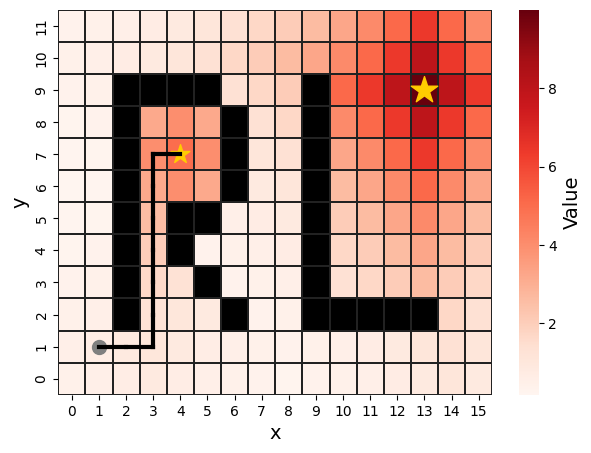

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
ax = gridworld.display_best_path(ax, val_iter.qualities, start_cell, values=val_iter.values)

### Checking the convergence

The following plot shows how the values of a few cells change through iterations of the algorithm until convergence.
The second plot shows the difference bewteen two consecutive values: it decreases exponentially until the convergence is reached.

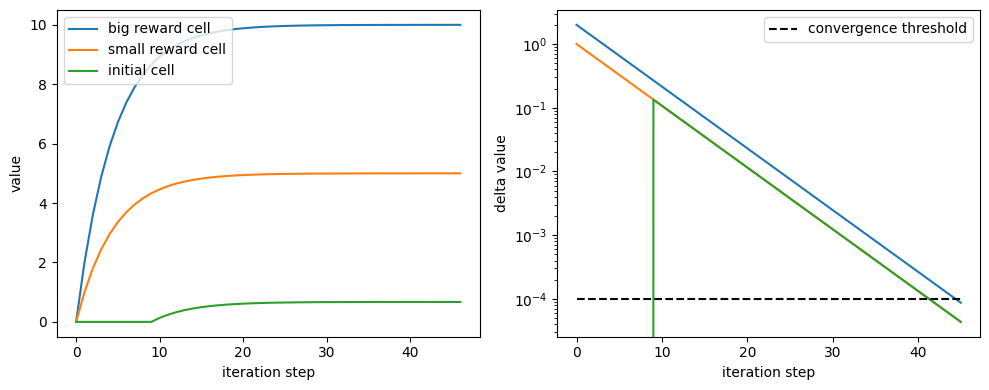

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.set_xlabel('iteration step')
ax1.set_ylabel('value')

ax1.plot(val_iter.values_traj[:,13,9], label='big reward cell')
ax1.plot(val_iter.values_traj[:,4,7], label='small reward cell')
ax1.plot(val_iter.values_traj[:,1,1], label='initial cell')

ax1.legend()


ax2.set_xlabel('iteration step')
ax2.set_ylabel('delta value')
ax2.set_yscale('log')

for x, y in [(13,9), (4,7), (1,1)]:
  dv = val_iter.values_traj[1:,x,y] - val_iter.values_traj[:-1,x,y]
  ax2.plot(dv)

ax2.plot(np.ones(len(dv)) * val_iter.eps_conv, c='k', ls='--', label='convergence threshold')
ax2.legend()

plt.tight_layout()

## Tasks

- Check that the value of the reward cells makes theoretically sense (you can esaily compute it analytically from the formula of the return).

- Try to change the discount factor such that the best strategy looks for the more distant treasure.

- Play with the world parameters: its size, the shape of the obstacles and the rewards, you can build amazing mazes!